# Introduction 

Numerical quadrature is a fundamental part of numerical analysis as the problem of computing integrals arises in many applications. In this project, I present the use of quadrature techniques in two such applications: the closely related problem of cubature, and the Nystrom method of solving Fredholm integral equations of the second kind. 

# Cubature

Although we discussed several numerical algorithms in class, there was little mention on how they extended to the problem of cubature: calculating N-dimensional integrals. This was because when nested quadrature rules are applied to evaluate multiple integrals, the number of function evaluations scales exponentially with the number of subdivisions. For example, the error of a $p$th order Newton-Cotes rule in $D$ dimensions is $\mathcal{O}(N^{-p/D})$, worsening an already slow algebraic convergence rate. This is the curse of dimensionality and to remedy it we studied three probabilistic cubature techniques: Monte Carlo Integration, Importance Sampling, and Recursive Stratified Sampling. By quantifying the error as the variance of an estimator of the mean, we were able to observe that the error was dimension-independent, thus allowing us to compute high-dimensional integrals with relative ease. Yet, the Monte-Carlo rules only had algebraic variance at $\mathcal{O}(N^{-1/2})$ (this was also the worst-case error for RSS). Here I would like to revisit cubature through nested quadrature rules and examine a case in which convergence is comparable (or perhaps better).

## The N-dimensional Paley-Wiener theorem and the rectangular rule

We have seen that although Newton-Cotes rules showed algebraic convergence in general, they exhibited exponential convergence for periodic functions. This was due to the fact that the Fourier co-efficients of periodic functions converged exponentially, so the error term could be bounded under an exponential. This raises the more interesting question of how Newton-Cotes rules fare in higher dimensions. A preliminary look at 2 dimensions is quite encouraging: 

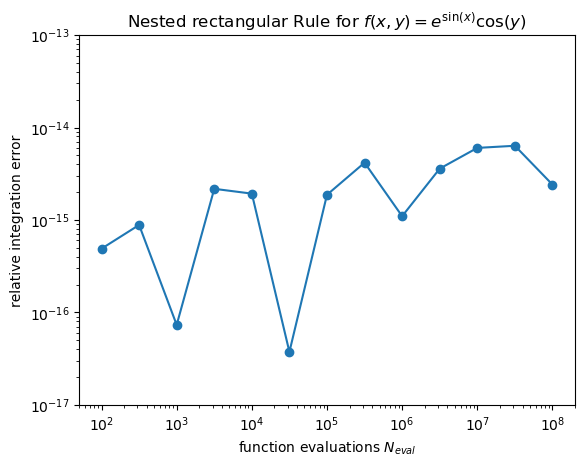

In [70]:
# estimate error
exact = 0.0

Ns = 10.0.^(1:0.25:4)

approximations = [nested_rect_2d(f, 0.0, 2*π, Int64(trunc(N))) for N in Ns]
errors = abs.(approximations)

figure()
loglog(Ns.^2, errors, "o-")
xlabel(L"function evaluations $N_{eval}$")
ylabel("relative integration error");
ylim(10^(-17),10^(-13))
title(L"Nested rectangular Rule for $f(x,y)=e^{\sin(x)}\cos(y)$");

Indeed, when we integrate $f(x,y) = e^{\sin(x)}\cos(y)$ on the domain $[0,2\pi] \times [0,2\pi]$, we get to machine accuracy in almost 100 function evaluations.

The rectangular rule in one dimension can be analysed as follows: Let $f$ be periodic and $C^{\infty}$ with the period $[0,T]$ and let $\{x_n\}$ be $N+1$ evenly spaced points (including the endpoints). Then each subinterval has length $T/N = \Delta$. In this case, the rectangular rule is given by 

$$ \int_{0}^{T}f(t)\,dt \approx \sum_{k=0}^{i=N-1}f(x_k)\Delta = \sum_{i=0}^{i=N-1}f\Big(\frac{kT}{N}\Big)\Delta$$

From the Fourier series formula we get that $f(t) = \sum_{n \in \mathbb{Z}}\widehat{f}(n)e^{-i\omega nt}$. Plugging the expression into the above equation we get that 

$$ \int_{0}^{T}f(t)\,dt \approx  I_N = \sum_{i=0}^{i=N-1}\Delta \sum_{n \in \mathbb{Z}}\widehat{f}(n)e^{-i\omega n\frac{kT}{N}} = \Delta\sum_{n \in \mathbb{Z}}\widehat{f}(n)\sum_{k=0}^{N-1}e^{-i\frac{2\pi}{T} n\frac{kT}{N}} = \Delta\sum_{n \in \mathbb{Z}}\widehat{f}(n)\sum_{k=0}^{N-1}e^{-i\frac{2\pi nk}{N}} $$

Now $\sum_{k=0}^{N-1}e^{-i\frac{2\pi nk}{N}} = N \iff n \in N\mathbb{Z}$ and 0 otherwise. As a consequence, 

$$ I_N \sum_{k \in N\mathbb{Z}}\widehat{f}(k) = T\widehat{f}(0) + T\sum_{k \in N\mathbb{Z^{*}}}\widehat{f}(k) \implies |I_N - I| \approx T\sum_{k \in N\mathbb{Z^{*}}}\widehat{f}(k)$$ 

Since $f$ is assumed to be smooth and periodic, we have that $|\widehat{f(k)}| \approx \mathcal{O}(e^{\alpha|k|})$. 

$$T\sum_{k \in N\mathbb{Z^{*}}}\widehat{f}(k) \approx \mathcal{O}(e^{-\alpha N}) + \mathcal{O}\Big(\sum_{k \in N\mathbb{Z^{*}} \setminus {N}}e^{\alpha|k|}\Big)$$

Since $\sum_{k \in N\mathbb{Z^{*}} \setminus {N}}e^{\alpha|k|} \leq 2\int_{N}^{\infty}e^{-\alpha x} dx = \frac{1}{\alpha}e^{-\alpha N}$, we get a bound as a function of $N$ only: 

$$ |I - I_N| \approx \mathcal{O}(e^{-\alpha N})$$

Now suppose $f: \mathbb{R}^D \mapsto \mathbb{R}$ and $f$ has period $T$ in each direction, i.e $f(x_1, \ldots x_k \ldots x_n) = f(x_1, \ldots x_k + T\ldots x_n) \, \forall \, k: 1 \leq k \leq n$ the $n$-dimensional Fourier series on $D = [0,T]^n$ is given by

$$ f(\textbf{x}) = \sum_{\textbf{k} \in \mathbb{Z}^n}\widehat{f(\textbf{k})}e^{i\omega\textbf{k}\cdot\textbf{x}}$$

where 

$$ \widehat{f(\textbf{k})} = \frac{1}{T^n}\int_{D}f(\textbf{x})e^{-i\omega \textbf{k}\cdot\textbf{x}}\,d\textbf{x}$$

We would like to estimate the following integral $I$ using the rectangular rule by subdivding each $[0,T]$ into $N$ intervals of size $T/N$

$$I = \int_{D}f(\textbf{x})\,d\textbf{x} \approx \sum_{0 \leq j_1 \leq N-1} \cdots \sum_{0 \leq j_n \leq N-1}(T/N)^{D}f(x_{j_1}, \ldots, x_{j_n}) = (T/N)^{D}\sum_{\textbf{j} \in \mathbb{Z}_{N}^{D}}f(\textbf{j})$$

We can substitute the Fourier series for $f$ in this expression, just like in the 1-D case. Furthermore, we can isolate the phase on each dimension because of the separability of the function $e^{-i\omega\textbf{k}\cdot\textbf{x}}$:

$$ (T/N)^{D}\sum_{\textbf{j} \in \mathbb{Z}_{N}^{D}}f(\textbf{j}) = 
(T/N)^{D}\sum_{\textbf{k} \in \mathbb{Z}^n}\widehat{f(\textbf{k})}\sum_{0 \leq j_1 \leq N-1}e^{-i\omega j_1\frac{T}{N}}\cdots\sum_{0 \leq j_D \leq N-1}e^{-i\omega j_D\frac{T}{N}}$$
$$ = (T/N)^{D}\sum_{\textbf{k} \in N\mathbb{Z}^D}\widehat{f(\textbf{k})}N^D = T^{D}\sum_{\textbf{k} \in N\mathbb{Z}^D}\widehat{f(\textbf{k})}$$

We would like a bound on the summation term. A rigorous result using the Cauchy integral formula on the complex torus can be found as Lemma 5.6 in Dynamical Systems and Chaos, Broer and Takens. Here I would like to provided a heuristic justification based on radial decay. It is most easily seen in 2 dimensions. Fix $x_0, y_0 \in \mathbb{R}$. Define $G(y) = f(x_0,y)$ and $F(x) = f(x, y_0)$. Now $F$ and $G$ are both periodic with period $T$ so they have Fourier coefficients. We can relate them to the coefficients of $f$ in the following way: 

$$ \widehat{f}(k,l) = \int_{0}^{T}\int_{0}^{T}f(x,y)e^{-i\omega kx}e^{-i\omega ly}\,dx\,dy = \int_{0}^{T}e^{-i\omega ly}\int_{0}^{T}f(x,y)e^{-i\omega kx}\,dx\,dy = \widehat{\widehat{F}(k)}(l) = \widehat{\widehat{G}(l)}(k)$$

where the last equality follows if we consider integrating on $y$ first instead of $x$. If $k$ and $l$ are fixed, $\widehat{F}$ and $\widehat{G}$ are both periodic functions in $y$ and $x$ respectively so their Fourier series co-efficients decay exponentially from the 1-D Paley-Wiener theorem. Thus, for a fixed $k$, $$\widehat{f}(k,l) \approx \mathcal{O}(e^{-\alpha_1|l|}) \iff |\widehat{f}(k,l)| \leq C_ke^{-\alpha_k|l|}$$, and for a fixed $l$, $$\widehat{f}(k,l) \approx \mathcal{O}(e^{-\alpha_2|k|}) \iff |\widehat{f}(k,l)| \leq C_le^{-\alpha_l|k|}$$ Note that these constant prefactors and decay rates $\textit{aren't}$ uniform: they depend on the fixed value. However, the constants themselves decay rapidly so we may bound them under a single uniform constant. Furthermore the decay rates $\alpha_i$ are bounded below by 0 so we can pick their infimum over the lattice that would give a slower rate of decay. Finally, to get a bound on the Fourier coefficient at a point in the $\mathbb{Z}^2$ lattice, we can approach the given point in the $x$ direction, incurring an exponential decay and then proceed to the point in the $y$ direction, incurring further decay. In this sense, the Fourier co-efficients decay radially. Thus, $|\widehat{f}(k,l)| \approx \mathcal{O}(e^{-\alpha(|k| + |l|})$. In the error for the rectangular rule $(k,l) \in N\mathbb{Z}^2$ so $|k| + |l| \geq N \iff e^{-\alpha(|k| + |l|} \leq e^{-\alpha N}$. Just as we did in the 1-D case, we can take the term with $N$ in the exponential and bound the rest of the series under another exponential with $N$ in the exponent. 

As a consequence, we have that 

$$ |I_N - I| \approx \mathcal{O}(T^{D}e^{-\alpha N})$$

Since $\sqrt[p]{N_{eval}} = N$, we have that $ |I_N - I| \approx \mathcal{O}(T^{D}e^{-\alpha \sqrt[p]{N_{eval}}})$. 

There are two points to note here. First, the rate of decay is slower with increasing dimension. Second, the constant prefactor increases exponentially with $D$. Although given a fixed dimension the rectangular rule converges exponentially, across dimensions the error term scales poorly. Thus, it seems that the initial view of the convergence of the rectangular rule for periodic functions was slightly misled: It may not scale as well over the dimension. 

Keeping the number of evaluations fixed at $N_{eval} = 1000$, I plotted the error for the integrals of the following 5-D periodic function 

$$f(x,y,z,w,a) = (2\sin^4(z) - 1)(\sin^5(a) - e^{\cos(a)} -1)e^{\sin(x)}\cos^2(y)$$

Since this function is separable, for each dimension I picked the part of the function that corresponded to those variables. For example, for the $1-D$ integration, I picked $f_1(x) = e^{\sin(x)}, f_2(x,y) = e^{\sin(x)}\cos^2(y)$ and so on. 

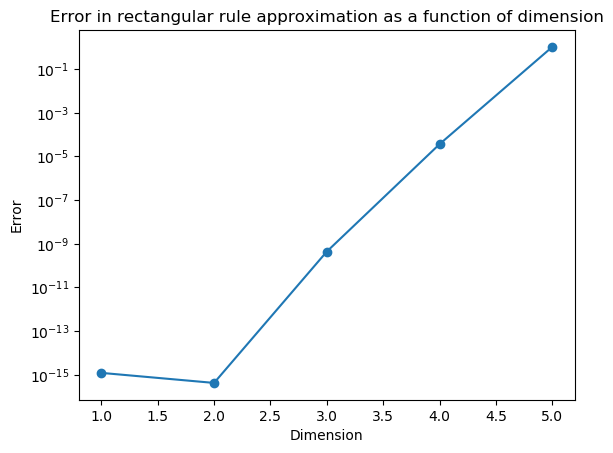

In [81]:
errs = abs.((approxs.-exacts)./exacts)
figure()
semilogy(LinRange(1,5,5), errs, "o-");
title("Error in rectangular rule approximation as a function of dimension");
xlabel("Dimension");
ylabel("Error");

# Integral equations 

Imagine you own a fish tank and you are wondering about the rate at which you should keep adding food to the tank. You observe that at any given time $t$, the proportion of food left in the tank is $k(t)$. Suppose initially there were $a$ ounces of food in the tank. If you add food at the rate $u(\tau)$ ounces per second, then in a small time interval you would have added $u(\tau)\Delta \tau$ ounces of food. Then at time $T$, $T-\tau$ seconds would have elapsed, so the proportion of food left over from the addition would be $k(T - \tau)u(\tau)\Delta \tau$. Integrating over $\tau$ from $0$ to $T$, the total amount of food in the tank at time $T$ is given by 

$F(T) = \int_{0}^{T}k(T-\tau)u(\tau)\,d\tau$

Suppose you would like there to be a constant amount of food at all times. Then the above equation becomes

$$ C = \int_{0}^{T}k(T-\tau)u(\tau)\,d\tau$$

This is known as an $\textit{Integral equation}$ because we are trying to solve for an unknown function $u$ with the knowledge of how it integrates against a function $k$. Integral equations are especially ubiquitous in several areas of physics, from potential theory to fluid dynamics. Just like their more famous counterpart, differential equations, they rarely have analytic solutions so numerical methods are all the more important to solve them. 

# Nyström's method for Fredholm equations of the second kind

Suppose we would like to solve the following integral equation: 

$$ f(t) = \lambda\int_{a}^{b}K(s,t)f(s)\,ds + g(t)$$

This is known as a Fredholm equation of the second kind. One approach to calculating $f$ is by applying a quadrature rule on the integral. Sampling at the points $t_i$ we get that 

$$ f(t_i) \approx \lambda\sum_{j=1}^{N}w_j K(t_i,s_j)f(s_j) + g(t_i)$$

We may interpret the summation as a matrix multiplication: 

$$ \sum_{j=1}^{N}w_j K(t_i,s_j)f(s_j) = \begin{bmatrix} w_1K(t_1,s_1) & \ldots & w_NK(t_1,s_N) \\ \vdots & \ddots & \vdots \\ w_1K(t_n,s_1) & \ldots & w_NK(t_n,s_N)\end{bmatrix}\begin{bmatrix}f(s_1) \\ \vdots \\ f(s_n) \end{bmatrix} = \textbf{K}\textbf{f}$$

Now if we set $t_j = s_j$ then we have the following matrix equation 

$$ \textbf{f} = \lambda\textbf{K}\textbf{f} + \textbf{g} $$

We can rearrange it to get 

$$ (I - \lambda\textbf{K})\textbf{f} = \textbf{g} $$

Solving for $\textbf{f}$ yields the values of $f$ at the sample points. But just because we know $f$ at finitely many points does not mean we know it everywhere on the interval. We still need to interpolate $f$ using some known functions. Nyström's insight was that we don't need to construct an interpolation: we already have it fr
om the quadrature rule. 

$$ f(t) = \lambda\sum_{j=1}^{N}w_j K(t,s_j)f(s_j) + g(t)$$

In the following example, I implement Nyström's method using two quadrature rules: Simpson's rule and Gauss-Legendre quadrature. Suppose the given integral equation is 

$$ f(x) = e^{-x} - \frac{1}{2} + \frac{1}{2}e^{-(x+1)} + \frac{1}{2}\int_{0}^{1}(x+1)e^{-xy}f(y)\,dy$$

Recall that the composite Simpson's rule is given as 

$$ I_N = \frac{1}{3}\Big(hf(a) + 2h\sum_{n=1}^{N-1}f(a + 2nh) + 4h\sum_{n=1}^{N}f(a + (2n-1)h) + hf(b)\Big)$$


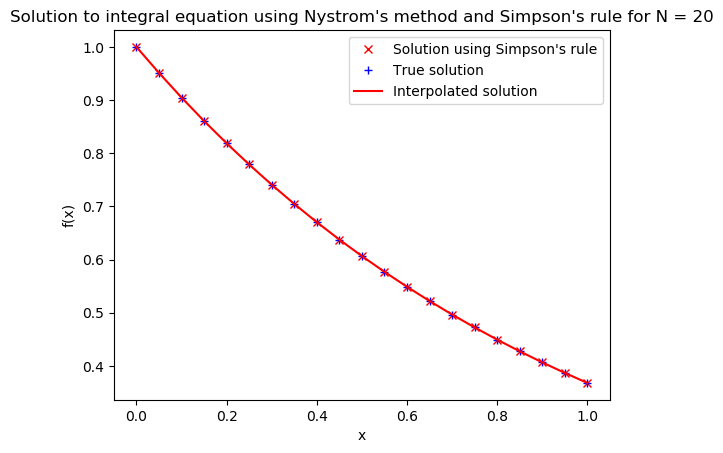

In [2]:
figure()

plot(samples, F, "rx", label="Solution using Simpson's rule")
plot(samples, exp.((-1).*samples), "b+", label="True solution")
plot(samples, s.(samples), "r-", label="Interpolated solution")
legend()
xlabel("x")
ylabel("f(x)")
title("Solution to integral equation using Nystrom's method and Simpson's rule for N = 20");

In order to use Gauss quadrature, note that we cannot implement it directly. The integral is on $[0,1]$ so we need to convert it to one on $[-1,1]$. Using the substitution $u = 2s - 1$, we get that 

$$ \frac{1}{2}\int_{s=0}^{s=1}(t+1)e^{-ty}f(s)\,ds = \lambda\int_{s=0}^{s=1}K(t,s)f(y)\,dy = \frac{\lambda}{2}\int_{u = -1}^{u = 1}K(t,\frac{u+1}{2})f(\frac{u+1}{2})\,du$$

Setting $K'(t,u) = K(t,\frac{u+1}{2})$ and $F(u) = f(\frac{u+1}{2})$, the integral becomes 

$$\frac{\lambda}{2}\int_{u = -1}^{u = 1}K'(t,u)f(u)\,du$$

This integral can be evaluated using Gauss-Legendre quadrature. One more detail remains: where should we sample the $t_i$'s? In order for Nystrom's method to work, the vector $\textbf{f}$ found at the left side of the discretized equation should match the vector $\textbf{F}$ on the right-hand side. As a consequence, we would like $f(t_i) = F(u_i)$ where $u_i$'s are the quadrature points. Since we know that $F(u) = f(\frac{u+1}{2})$, $F(u_i) = f(\frac{u_i+1}{2}) = f(t_i) \iff t_i = \frac{u_i+1}{2}$



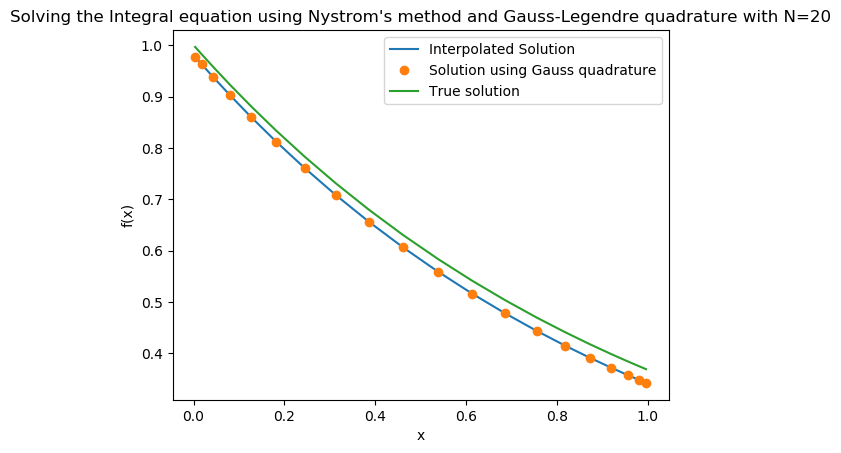

In [53]:
figure()

plot(tis,interpolation.(tis), label="Interpolated Solution");
plot(tis, Points, "o", label="Solution using Gauss quadrature");
plot(tis, exp.((-1).*tis), label="True solution")
title("Solving the Integral equation using Nystrom's method and Gauss-Legendre quadrature with N=20")
ylabel("f(x)")
xlabel("x");
legend();

This result might suggest that Gauss-Legendre quadrature does worse at solving integral equations. This is in general is not true. The point of Nystrom's interpolation formula is that if we denote $f_{I}$ as the interpolated solution, then we have 

$$ f_{I}(t) = \lambda\sum_{i=1}^{N}K(t,s_i)f(s_i)w_i + g(t) \text{ and }$$

$$ f(t) = \lambda\int_{a}^{b}K(t,s)f(s)\,ds + g(t) $$

$$ \implies |f - f_{I}(t)| =  \Big|\,\lambda\sum_{i=1}^{N}K(t,s_i)f(s_i)w_i + g(t) - \lambda\int_{a}^{b}K(t,s)f(s)\,ds + g(t)\,\Big| = \varepsilon_I$$

Here $\varepsilon_I$ is the error in the quadrature rule. Thus, Nystrom's method finds a way to bring the error down to the quadrature rule that we use, so in general Gauss-Legendre quadrature should do better than Simpson's rule as the number of samples increase. But this fails spectacularly when we consider $N = 40$ for Gauss-Legendre quadrature: 

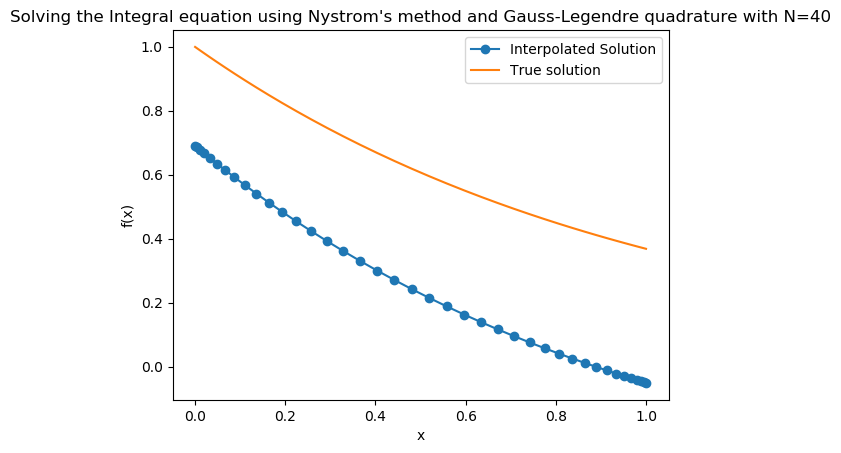

In [62]:

time = Nystrom_Gauss(40)[1]
interpola = Nystrom_Gauss(40)[2]

figure()
plot(time, interpola, "o-", label="Interpolated Solution")
plot(time, exp.((-1).*time), label="True solution")
title("Solving the Integral equation using Nystrom's method and Gauss-Legendre quadrature with N=40")
ylabel("f(x)")
xlabel("x");
legend();

This is actually due to an implementation issue with the Legendre Polynomials. If we look at the Gaussian weights for $N=15$, they match the exact ones found in (insert source here):

In [63]:
print(Gaussian_weights(15))

[0.0307532, 0.070366, 0.107159, 0.139571, 0.166269, 0.186161, 0.198431, 0.202578, 0.198431, 0.0307532, 0.070366, 0.107159, 0.139571, 0.186161, 0.166269]

However, for $N \geq 40$, the following phenomenon occurs: 

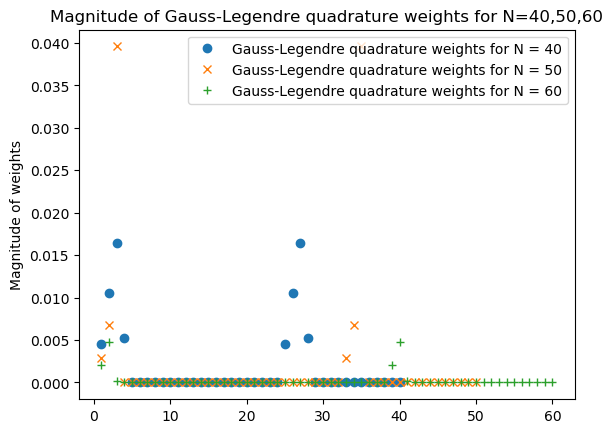

Gauss-Legendre weights for N=40: [0.00452128, 0.0104983, 0.016455, 0.00525662, 9.36748e-7, 4.24951e-10, 9.8906e-13, 7.92536e-15, 1.71569e-16, 8.55044e-18, 8.80625e-19, 1.74438e-19, 6.36333e-20, 4.20734e-20, 5.14645e-20, 1.28016e-19, 9.30014e-19, 8.60171e-16, 1.03021e-17, 4.8897e-17, 4.8897e-17, 1.03021e-17, 8.60171e-16, 9.30014e-19, 0.00452128, 0.0104983, 0.016455, 0.00525662, 9.36748e-7, 4.24951e-10, 9.8906e-13, 7.92536e-15, 1.71569e-16, 8.55044e-18, 1.28016e-19, 8.80625e-19, 1.74438e-19, 5.14645e-20, 6.36333e-20, 4.20734e-20]

In [73]:
print("Gauss-Legendre weights for N=40: ",Gaussian_weights(40))

figure()

plot([i for i in 1:40], Gaussian_weights(40),"o",label="Gauss-Legendre quadrature weights for N = 40")
plot([i for i in 1:50], Gaussian_weights(50),"x",label="Gauss-Legendre quadrature weights for N = 50")
plot([i for i in 1:60], Gaussian_weights(60),"+",label="Gauss-Legendre quadrature weights for N = 60")
legend();
ylabel("Magnitude of weights");
title("Magnitude of Gauss-Legendre quadrature weights for N=40,50,60");

Only the first 4 weights computed by the function are precise and the rest of them are zero, or very close to zero. This phenomenon is actually due to the repeated evaluations of high-order Legendre polynomials which are computed using Julia's imprecise $\textit{binom}$ function. In fact, the Gaussian weights function provided in the lecture notes fares worse than the function being used for this implementation: 

In [77]:
#Weights function provided in the lecture notes 

function weights_matrix(N, x)
    """ Construct the matrix B with entries
    B_{ij} = Q_i(x_j)
    """
    Q = [legendre(n) for n=0:N-1]
    
    [Q[i](x[j]) for i=1:length(Q), j=1:length(x)]
end

N = 20
xn = LinRange(-1, 1, N)
W = weights_matrix(N, xn)

# rhs
b = zeros(N)
b[1] = 2.0 


print("Gauss-Legendre quadrature weights for N=20: ",W \ b)

Gauss-Legendre quadrature weights for N=20: [0.0256708, 0.22449, -0.344679, 1.5997, -3.84667, 8.3066, -13.1394, 16.3335, -13.7926, 5.63345, 5.63345, -13.7926, 16.3335, -13.1394, 8.3066, -3.84667, 1.5997, -0.344679, 0.22449, 0.0256708]

The method given in the lecture notes involves evaluating all of the first $N-1$ Legendre polynomials $N$ times. Evaluating an $Nth$ order Legendre polynomial calls the $\textit{binom}$ function $N$ times, so evaluating all $N-1$ polynomials, each $N$ times, calls the $\textit{binom}$ function $\mathcal{O}(N^3)$ times. This can cause errors to add up. The formula found in Abramovitz and Stegun gives the following formula for evaluating the weights: 

$$ w_i = \frac{2(1-x^2)}{(NP_{N-1}(x_i))^{2}}$$

Here $x_i$ is the $i$th root of the $N$th order Legendre Polynomial. This formula brings down the number of evaluations to $N$, which we were already making in the previous algorithm. Such an implementation has brought up the accuracy to $N=35$, but for $N \geq 36$, the same issues arise. 

There are, of course, better ways to evaluate the Legendre polynomials, found online and at (insert sources). One possible way is to use the derivative definition for the Legendre polynomials: 

$$ P_n(x) = \frac{1}{n!}\dfrac{d^n}{dx^n}(x^2 - 1) $$

We could use the $\textit{ForwardDiff.jl}$ package here and compute derivatives recursively to high precision. For computing $n!$, we could use either the approximations provided by the Gamma function or Stirling's formula. Yet, both approaches leave a lot to be desired as the Gamma function involves computing a singular integral and Stirling's formula is accurate only at large $N$. 

# Summary

In this project, I explored two applications of weighted quadrature rules: the rectangular rule's use in cubature for periodic functions and the Nystrom method for calculating solutions to Integral equations. In the first application, I observed a convergence rate for the the rectangular rule that converged exponentially fast for fixed dimension but worsened exponentially given fixed evaluations and increasing dimension. In the second application, I compared two implementations of the Nystrom method using Simpson's rule and Gauss-Legendre quadrature. In the given example, Simpson's rule performed better than Gauss-Legendre in terms of the accuracy of the interpolated solution. This in  general is not true: the accuracy of Nystrom's method depends on the accuracy of the quadrature rule. Furthermore, the case for $N=40$ revealed interesting flaws in the implementation of the Legendre polynomials.

# Code Listing


In [ ]:
# N-D integration 

function rectangular_rule(f, a, b, N)
Δ = (b - a)/N
I = 0.0
for n=0:N-1
I += Δ*f(a + n*Δ)
end
return I
end
# f(x, y) = (e^sin(x))*cos(x)
f(x,y) = exp(sin(x))*(cos(y))

function nested_rect_2d(f, a, b, N)
# inner integral
F(x_1) = rectangular_rule(x_2 -> f(x_1, x_2), a, b, N)
# outer integral
return rectangular_rule(F, a, b, N)
end

function nested_rect_3d(f, a, b, N)
# inner integral
F(x_1) = nested_rect_2d((x_2,x_3) -> f(x_1, x_2, x_3), a, b, N)
# outer integral
return rectangular_rule(F, a, b, N)
end

function nested_rect_4d(f, a, b, N)
# inner integral
F(x_1) = nested_rect_3d((x_2,x_3,x_4) -> f(x_1, x_2, x_3, x_4), a, b, N)
# outer integral
return rectangular_rule(F, a, b, N)
end

function nested_rect_5d(f, a, b, N)
# inner integral
F(x_1) = nested_rect_4d((x_2,x_3,x_4,x_5) -> f(x_1, x_2, x_3, x_4,x_5), a, b, N)
# outer integral
return rectangular_rule(F, a, b, N)
end

exacts = zeros(5)
exacts[1] = 7.954926521012845274513219665329394328161342771816638573
exacts[2] = exacts[1]*π
exacts[3] = exacts[2]*(-π/2)
exacts[4] = exacts[3]*9π
exacts[5] = exacts[4]*-14.2381118281924317514385064318884000965556815705668502
approxs = zeros(5)

f1(x) = exp(sin(x))
approxs[1] = rectangular_rule(f1, 0, 2*pi, 1000)

f2(x,y) = exp(sin(x))*(cos(y))^2
approxs[2] = nested_rect_2d(f2, 0, 2*pi, 32)

f3(x,y,z) = exp(sin(x))*((cos(y))^2)*(2*(sin(z))^4 - 1)
approxs[3] = nested_rect_3d(f3, 0, 2*π, 10)
# 7.954926521012845274513219665329394328161342771816638573 * (-pi/2) * pi

f4(x,y,z,w) = exp(sin(x))*((cos(y))^2)*(2*(sin(z))^4 - 1)*(9*(cos(w))^2)
approxs[4] = nested_rect_4d(f4,0,2*π, 6)
#7.954926521012845274513219665329394328161342771816638573 * (-π/2) *π* 9π

f5(x,y,z,w,a) = exp(sin(x))*((cos(y))^2)*(2*(sin(z))^4 - 1)*(9*(cos(w))^2)*((sin(a))^5 - exp(cos(a)) - 1)
approxs[5] = nested_rect_5d(f5, 0, 2*π, 4)
#7.954926521012845274513219665329394328161342771816638573 * (-π/2) *π* 9π-14.238111828192431751438506431888400096555

#Nystrom's method

function simpson_matrix(N,a,b,K,samples)

    S = zeros(2*N + 1, 2*N + 1)
    h = (b-a)/(2*N)
    for i in 1:2*N + 1
            if i == 1
            S[i,i] = (1/3)*h
            elseif i == 2*N + 1
            S[i,i] = (1/3)*h
            elseif i%2 == 0
            S[i,i] = (1/3)*4*h
            else 
            S[i,i] = (1/3)*2*h
        end
    
    end
    
    Kmatrix = zeros(2*N + 1, 2*N + 1)
    for i in 1:2*N + 1 
        for j in 1:2*N + 1
            Kmatrix[i,j] = K(samples[i],samples[j])
        end
    end


    
    return Kmatrix*S
end

function solution(t,weights,F,K,g,samples,λ)
    sols = 0.0
    for i in 1:size(F)[1]
        sols = sols + weights[i]*K(t,samples[i])*F[i]
    end
    return λ*sols + g(t)
end

K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))

N = 10
samples = LinRange(0,1,2*N + 1)
λ = (1/2)
a = 0 
b = 1
G = g.(samples)
Kmat = simpson_matrix(N,0,1,K,samples) #compute matrix
Id = zeros(2*N + 1, 2*N + 1) + I
M = (Id - λ*Kmat)
F = M \ G

S = zeros(2*N + 1, 2*N + 1)
    h = (b-a)/(2*N)
    for i in 1:2*N + 1
            if i == 1
            S[i,i] = (1/3)*h
            elseif i == 2*N + 1
            S[i,i] = (1/3)*h
            elseif i%2 == 0
            S[i,i] = (1/3)*4*h
            else 
            S[i,i] = (1/3)*2*h
        end
    
    end

weights = zeros(2*N + 1)
for i in 1:size(weights)[1]
   weights[i] = S[i,i]
end

s(t) = solution(t,weights,F,K,g,samples,λ)
#zeros(2*10 + 1, 2*10 + 1)

figure()

function legendre(n)
    """ Use explicit formula to evaluate Legendre Polynomial P_n
    """
    function Pn(x)
        f = 0.0
        for k=0:n
            f += 2.0^(-n) * binomial(n, k)^2 * (x - 1)^(n - k) * (x + 1)^k
        end
        return f
    end
end

#function weights_matrix(N, x)
#    """ Construct the matrix B with entries
#    B_{ij} = Q_i(x_j)
#    """
#    Q = [legendre(n) for n=0:N-1]
    
#    [Q[i](x[j]) for i=1:length(Q), j=1:length(x)]
#end

α(n) = n/(2n+1)
β(n) = 0
γ(n) = (n+1)/(2n+1)

# construct matrix
A(N) = diagm(   0 => β.(0:N-1),
             1 => γ.(0:N-2),
            -1 => α.(1:N-1))


# weight matrix for Gaussian samples
function Gaussian_weights(N)
    
    A_N = A(N)
xn = sort(eigvals(A_N)) # roots of Q_N(x)

Q = legendre(N-1)
w = 2 .*(1 .- (xn).^2)./((N*Q.(xn)).^2)
    
return w
end




K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))
Kprime(t,u) = K(t,(u+1)/2)
λ = (1/2)
N = 20
A_N = A(N)
Gsamples = sort(eigvals(A_N))
tis = (Gsamples .+ 1)./2
Gweights = Gaussian_weights(N)
GaussMatrix = zeros(N,N)
for i in 1:N
    for j in 1:N
        GaussMatrix[i,j] = (λ/2)*Kprime(tis[i],Gsamples[j])*Gweights[j]
    end
end

#WeightMatrix = diagm( 0 => Gweights)

Id = zeros(N,N) + I

Solver = Id - GaussMatrix

Points = Solver \ g.(tis)

function sols(t,Gweights,Points,Kprime,g,samples,λ)
    sum = 0.0
    for i in 1:size(Points)[1]
        sum = sum + Gweights[i]*Kprime(t,samples[i])*Points[i]
    end
    return (λ/2)*sum + g(t)
end

interpolation(t) = sols(t,Gweights,Points,Kprime,g,Gsamples,λ)